# Image processing functions

In [33]:
import numpy as np  # type: ignore
import onnx
from onnx import parser
from onnx import checker
from onnx import helper
from onnx import TensorProto as tp
from onnx import save
import onnxruntime

op = onnx.OperatorSetIdProto()
op.version = 16

import os
os.environ["ALLOW_RELEASED_ONNX_OPSET_ONLY"] = "0"


Output sizes: 
(266, 400, 3)
(348, 348, 3)


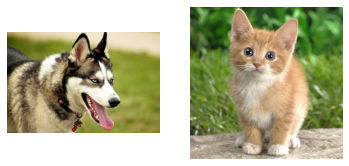

In [34]:
# display images in the notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):
    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(np.array(images[i]).shape)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()

images = [
    Image.open('../assets/dog.jpg'),
    Image.open('../assets/cat.jpg')
]
show_images(images)

def show(onnx_model_path, inputs):
    session = onnxruntime.InferenceSession('centered_crop.onnx', None)
    out_imgs = []
    for i in range(len(inputs)):
        result = session.run([], inputs[i])
    out_imgs.append(Image.fromarray(result[0]))
    show_images(out_imgs)

## CenterCrop


Output sizes: 
(200, 200, 3)
(200, 200, 3)


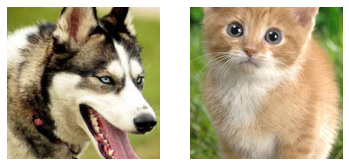

In [35]:
centered_crop = parser.parse_graph('''
    centered_crop (uint8[H1, W1, C] image, int64[2] crop_win) => (uint8[H2, W2, C] out_image)
    {
        k2 = Constant <value = int64[1] {2}> ()
        axes = Constant <value = int64[2] {0, 1}> ()
        x_shape = Shape (image)
        h, w, c = Split <axis = 0> (x_shape)
        hw = Concat <axis = 0> (h, w)
        hw_diff = Sub (hw, crop_win)
        start_xy = Div (hw_diff, k2)
        end_xy = Add (start_xy, crop_win)
        out_image = Slice (image, start_xy, end_xy, axes)
    }
    ''')
checker.check_graph(centered_crop)
model = helper.make_model(centered_crop, producer_name='test', opset_imports=[op])
checker.check_model(model)
onnx.save(model, 'centered_crop.onnx')

crop_win = np.array([200, 200], dtype=np.int64)

session = onnxruntime.InferenceSession('centered_crop.onnx', None)
out_images = []
for image in images:
    result = session.run([], {'image': np.array(image), 'crop_win': crop_win})
    out_images.append(Image.fromarray(result[0]))
show_images(out_images)


## Resize (not-smaller)

Output sizes: 
(200, 300, 3)
(200, 200, 3)


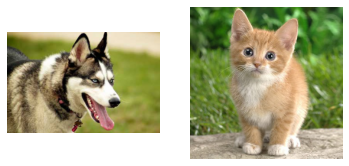

In [36]:
resize_not_smaller = parser.parse_graph('''
    resize_not_smaller (uint8[H1, W1, C] image, int64[2] target_size) => (uint8[H2, W2, C] out_image)
    {
        image_shape = Shape (image)
        h, w, c = Split <axis = 0> (image_shape)
        hw = Concat <axis = 0> (h, w)
        hw_f = Cast <to = 1> (hw)
        target_size_f = Cast <to = 1> (target_size)
        ratios = Div(target_size_f, hw_f)
        ratio_resize = ReduceMax(ratios)
        k1f = Constant <value = float[1] {1.0}> ()
        scales_resize = Concat <axis = 0> (ratio_resize, ratio_resize, k1f)
        out_image = Resize <mode = \"linear\"> (image, , scales_resize)
    }
    ''')
checker.check_graph(resize_not_smaller)
model = helper.make_model(resize_not_smaller, producer_name='test', opset_imports=[op])
checker.check_model(model)
onnx.save(model, 'resize_not_smaller.onnx')

target_size = np.array([200, 200], dtype=np.int64)

session = onnxruntime.InferenceSession('resize_not_smaller.onnx', None)
out_images = []
for image in images:
    result = session.run([], {'image': np.array(image), 'target_size': target_size})
    out_images.append(Image.fromarray(result[0]))
show_images(out_images)

## Resize (not-larger)

Output sizes: 
(133, 200, 3)
(200, 200, 3)


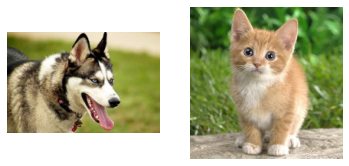

In [37]:
resize_not_larger = parser.parse_graph('''
    resize_not_larger (uint8[H1, W1, C] image, int64[2] target_size) => (uint8[H2, W2, C] out_image)
    {
        image_shape = Shape (image)
        h, w, c = Split <axis = 0> (image_shape)
        hw = Concat <axis = 0> (h, w)
        hw_f = Cast <to = 1> (hw)
        target_size_f = Cast <to = 1> (target_size)
        ratios = Div(target_size_f, hw_f)
        ratio_resize = ReduceMin(ratios)
        k1f = Constant <value = float[1] {1.0}> ()
        scales_resize = Concat <axis = 0> (ratio_resize, ratio_resize, k1f)
        out_image = Resize <mode = \"linear\"> (image, , scales_resize)
    }
    ''')
checker.check_graph(resize_not_larger)
model = helper.make_model(resize_not_larger, producer_name='test', opset_imports=[op])
checker.check_model(model)
onnx.save(model, 'resize_not_larger.onnx')

target_size = np.array([200, 200], dtype=np.int64)

session = onnxruntime.InferenceSession('resize_not_larger.onnx', None)
out_images = []
for image in images:
    result = session.run([], {'image': np.array(image), 'target_size': target_size})
    out_images.append(Image.fromarray(result[0]))
show_images(out_images)